In [1]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from tqdm.notebook import tqdm
import pandas as pd
from matplotlib.colors import ListedColormap

import constants as k
import utils

In [2]:
data_dir = '/Users/rebekahzhang/data/neural_data'
pickle_dir = Path(os.path.join(data_dir, 'session_pickles'))
figure_dir = os.path.join(data_dir, 'figures')

In [3]:
viridis_palette = ListedColormap(plt.cm.viridis(np.linspace(0, 1, 5)))  # generating 5 colors for 4 quantile + missed
colors = [viridis_palette(i) for i in range(5)]
quantile_colors = colors[:4]
missed_color = colors[4]

In [4]:
units_vetted = pd.read_csv(os.path.join(data_dir, 'units_vetted.csv'), index_col=0).sort_values('unit_id')
sessions_vetted = pd.read_csv(os.path.join(data_dir, 'sessions_vetted.csv'), index_col=0).sort_values('num_units')

In [5]:
units_grouped = units_vetted.groupby("session_id")

In [6]:
def get_data_for_debugging(units_vetted=units_vetted, session_id='RZ036_2024-07-13_str', unit_id=15):
    units_grouped = units_vetted.groupby("session_id")
    test_group = units_grouped.get_group('RZ036_2024-07-13_str')
    session_id = test_group['session_id'].iloc[0]
    events, trials, units = utils.get_session_data(session_id, pickle_dir)
    spikes = units[unit_id]
    return events, trials, spikes
events, trials, spikes = get_data_for_debugging()

### raster plot

In [7]:
def prepare_data_for_raster(events, trials, spikes, sorter):
    sorted_trial_id = trials.sort_values(by=sorter).trial_id.tolist()
    events_raster = events.groupby('trial_id')
    spikes_raster = spikes.groupby('trial_id')
    return events_raster, spikes_raster, sorted_trial_id

def plot_raster(ax, sorted_trial_id, events_raster, spikes_raster, anchor, anchored_periods, show_legend=True):
    ax.axvline(0, color='tab:gray', linestyle='--', alpha=0.5, label=anchor)

    event_colors = {
        'visual': 'g',
        'wait': 'orange', 
        'cons_reward': 'b', 
        'cons_no_reward': 'r'
    }

    for trial_offset, t in enumerate(sorted_trial_id):
        # Plot trial events
        trial_events = events_raster.get_group(t)
        for event_type, color in event_colors.items():
            event_time = trial_events.loc[trial_events['event_type'] == event_type, anchor]
            ax.eventplot(
                event_time, lineoffsets=trial_offset, color=color, 
                linelengths=1.0, linewidths=0.8, alpha=1
            )

        if t in spikes_raster.groups:
            trial_spikes = spikes_raster.get_group(t)
            relevant_periods = anchored_periods[anchor]
            relevant_spike_times = trial_spikes.loc[trial_spikes.period.isin(relevant_periods), anchor]
            # Plot spikes (black)
            ax.eventplot(
                relevant_spike_times, 
                lineoffsets=trial_offset, 
                color='k', 
                linelengths=0.8, 
                linewidths=0.4
            )
            irrelevant_spike_times = trial_spikes.loc[~trial_spikes.period.isin(relevant_periods), anchor]
            ax.eventplot(
                irrelevant_spike_times, 
                lineoffsets=trial_offset, 
                color='darkgrey', 
                linelengths=0.8, 
                linewidths=0.4
            )
        else:
            continue
    # Create legend only for the last raster plot
    if show_legend:
        handles = [plt.Line2D([0], [0], color=c, lw=2, label=label) 
                   for label, c in event_colors.items()]
        ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.92))

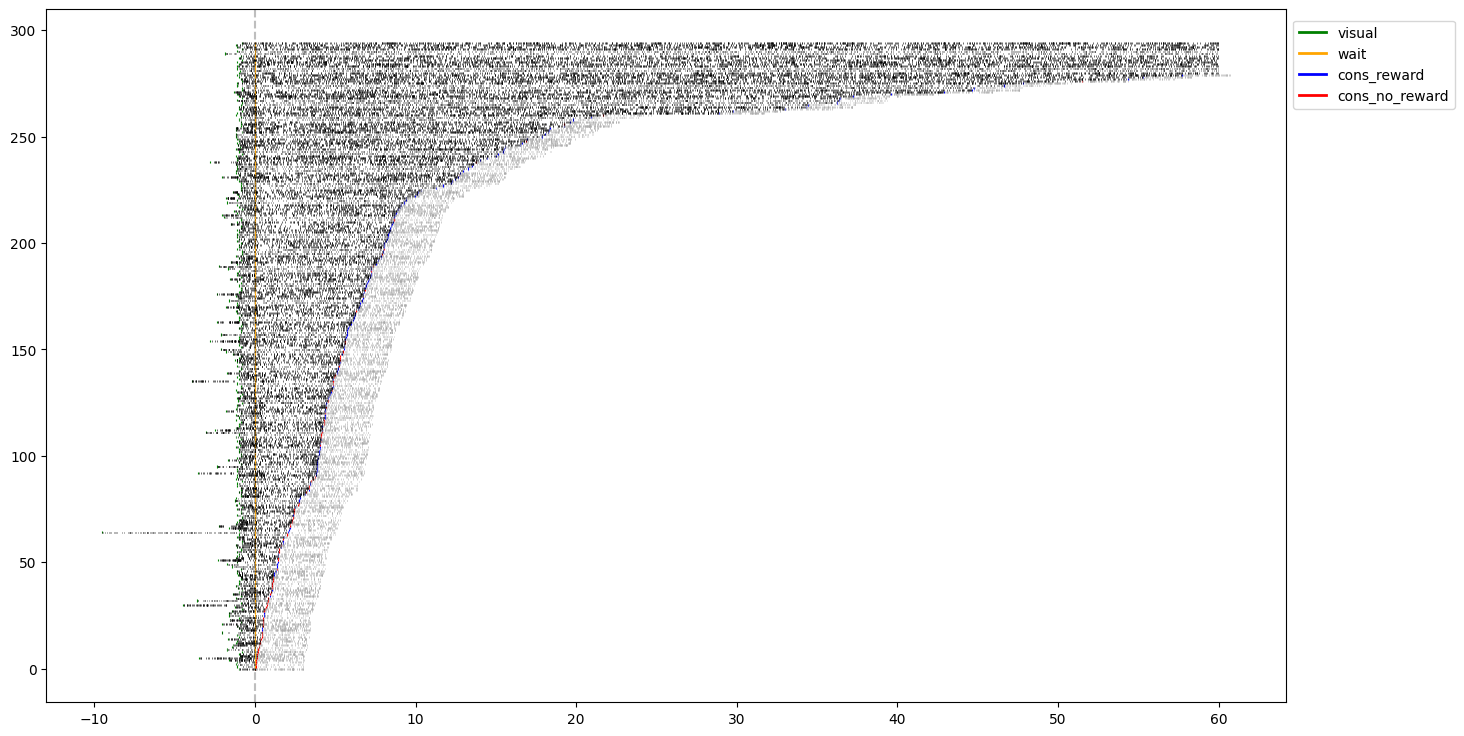

In [8]:
anchor = k.TO_CUE_OFF
sorter = k.WAIT_LENGTH
_, ax = plt.subplots(figsize=(16,9))
events_raster, spikes_raster, sorted_trial_id = prepare_data_for_raster(events, trials, spikes, sorter)
plot_raster(ax, sorted_trial_id, events_raster, spikes_raster, anchor, k.anchored_periods)

### histo plot

In [9]:
def prepare_data_for_histogram(trials, spikes, anchor, anchored_periods, sorter):
    # Calculate the aligned start and end time based on the anchor
    if anchor == k.TO_CUE_ON:
        # boundaries: trial start (0) -> cue off time
        trials['aligned_start_time'] = 0 - trials["cue_on_time"]
        trials['aligned_end_time'] = trials['cue_off_time'] - trials["cue_on_time"]
    
    elif anchor == k.TO_CUE_OFF:
        # boundaries: cue on time -> consumption time (or trial_length if consumption is missing)
        trials['aligned_start_time'] = trials['cue_on_time'] - trials["cue_off_time"]
        # Handle missing decision_time
        mask = trials['decision_time'].isna()
        trials.loc[~mask, 'aligned_end_time'] = trials['decision_time'] - trials["cue_off_time"]
        trials.loc[mask, 'aligned_end_time'] = trials['trial_length'] - trials["cue_off_time"]
    
    elif anchor == k.TO_DECISION:
        # boundaries: cue off time -> trial end
        trials['aligned_start_time'] = trials["cue_off_time"] - trials["decision_time"]
        trials['aligned_end_time'] = trials['trial_length'] - trials["decision_time"]
    
    # Calculate quantiles only on non-missed trials
    non_missed_trials = trials[~trials['missed']].copy()
    non_missed_trials['quantile'] = pd.qcut(non_missed_trials[sorter], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    # missed trials will have NaN quantile
    trials = trials.merge(non_missed_trials[['trial_id', 'quantile']], on='trial_id', how='left')

    # get spikes from ancored periods
    relevant_periods = anchored_periods[anchor]
    relevant_spikes = spikes.loc[spikes.period.isin(relevant_periods)].copy()
    
    # get trials with spikes
    trials_with_spikes = relevant_spikes['trial_id'].unique()
    trials_histo = trials[trials['trial_id'].isin(trials_with_spikes)].copy().sort_values('quantile')
    
    trials_to_merge = trials_histo[['trial_id', 'quantile']].copy()
    spikes_histo = pd.merge(relevant_spikes, trials_to_merge, on='trial_id', how='inner')
    
    return trials_histo, spikes_histo

In [10]:
def generate_time_frame(trials, time_step, trial_count_mask=1):
    """
    Generate time bins and active trial counts.
    """
    # Calculate bounds (with protection against empty data)
    if len(trials) == 0:
        return np.array([]), np.array([]), np.array([])
        
    bounds = (
        np.round(trials.aligned_start_time.min(), decimals=1),
        np.round(trials.aligned_end_time.max(), decimals=1)
    )
    
    # Create bins
    bin_edges = np.arange(
        bounds[0] - time_step,
        bounds[1] + 2*time_step,
        time_step
    )
    bin_centers = bin_edges[:-1] + time_step/2
    
    # Calculate active trials
    active_trials = np.zeros(len(bin_edges) - 1, dtype=int)
    for _, trial in trials.iterrows():
        occupied = (bin_edges[:-1] < trial['aligned_end_time']) & \
                  (bin_edges[1:] > trial['aligned_start_time'])
        active_trials[occupied] += 1

    # Apply mask with safety checks
    if trial_count_mask > 0:
        valid_mask = active_trials >= trial_count_mask
        if not np.any(valid_mask):  # No valid bins
            return np.array([]), np.array([]), np.array([])
            
        bin_edges = np.append(
            bin_edges[:-1][valid_mask],
            bin_edges[:-1][valid_mask][-1] + time_step
        )
        bin_centers = bin_centers[valid_mask]
        active_trials = active_trials[valid_mask]
        
    return bin_edges, bin_centers, active_trials

In [11]:
def calculate_firing_rates(trials, spikes, anchor, time_step, trial_count_mask=5, sigma=0.01):
    bin_edges, bin_centers, active_trials = generate_time_frame(trials, time_step, trial_count_mask)
    
    # Handle case where no bins meet criteria
    if len(bin_edges) == 0:
        return np.array([]), np.array([]), np.array([])

    # Bin spikes for each trial, shape is [trial, bin]
    counts = np.array([
        np.histogram(trial[anchor], bins=bin_edges)[0]
        for _, trial in spikes.groupby('trial_id')
    ])
    rates = counts / time_step

    mean_fr = np.nansum(rates, axis=0) / active_trials
    sem_fr = np.std(rates, axis=0) / np.sqrt(active_trials)

    if sigma > 0:
        mean_fr = gaussian_filter1d(mean_fr, sigma=sigma)
        sem_fr = gaussian_filter1d(sem_fr, sigma=sigma)

    return bin_centers, mean_fr, sem_fr

In [12]:
def plot_firing_rates_for_quantile(ax, trials, spikes, anchor, time_step, sigma, trial_count_mask, show_legend=True):
    """Plots firing rates on given axes with legend on the right."""
    ax.axvline(0, color='tab:gray', linestyle='--', alpha=0.5, label=anchor)
    
    # Calculate rates for all trials
    bin_centers, mean_fr, sem_fr = calculate_firing_rates(
        trials, spikes, anchor, time_step, trial_count_mask, sigma
    )
    if len(bin_centers) > 0:
        ax.plot(bin_centers, mean_fr, 'k-', lw=1.5, alpha=0.8, label='All trials')
        ax.fill_between(bin_centers, mean_fr-sem_fr, mean_fr+sem_fr, color='gray', alpha=0.4)
        # trials_sorted = trials.sort_values('quantile')
    
    for i, quantile in enumerate(trials['quantile'].unique()):
        trials_quantile = trials.loc[trials['quantile'] == quantile]
        spikes_quantile = spikes.loc[spikes['quantile'] == quantile]
        bin_centers_q, mean_fr_q, sem_fr_q = calculate_firing_rates(
            trials_quantile, spikes_quantile, anchor, time_step, trial_count_mask, sigma
            )
        if len(bin_centers_q) > 0:
            ax.plot(bin_centers_q, mean_fr_q, color=quantile_colors[i], lw=1, alpha=0.8, label=quantile)
            ax.fill_between(bin_centers_q, mean_fr_q-sem_fr_q, mean_fr_q+sem_fr_q, color=quantile_colors[i], alpha=0.3)
    
    # Missed trials (missed=True)
    if anchor != k.TO_DECISION:
        trials_missed = trials.loc[trials.missed == True]
        spikes_missed = spikes.loc[spikes.trial_id.isin(trials_missed.trial_id)]
        bin_centers_m, mean_fr_m, sem_fr_m = calculate_firing_rates(
            trials_missed, spikes_missed, anchor, time_step, trial_count_mask, sigma
        )
        if len(bin_centers_m) > 0:
            ax.plot(bin_centers_m, mean_fr_m, color=missed_color, linestyle='-', lw=1, alpha=0.8, label='Missed')
            ax.fill_between(bin_centers_m, mean_fr_m-sem_fr_m, mean_fr_m+sem_fr_m, color=missed_color, alpha=0.3)

    # Add the firing rate legend to the right of the plot
    if show_legend:
        ax.legend(bbox_to_anchor=(1, 1.05), loc='upper left')

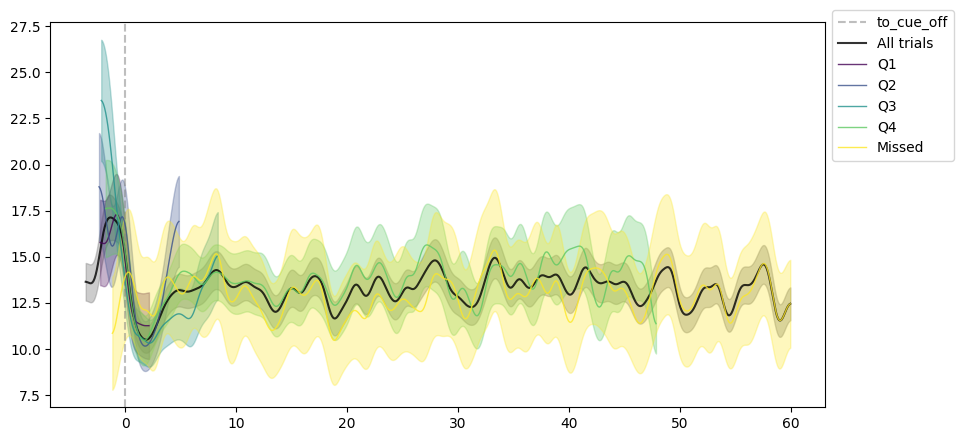

In [13]:
anchor = k.TO_CUE_OFF
sorter = k.WAIT_LENGTH
time_step = 0.1
sigma = 5
trial_count_mask = 5

_, ax = plt.subplots(figsize=(10, 5))
events, trials, spikes = get_data_for_debugging()
trials_histo, spikes_histo = prepare_data_for_histogram(trials, spikes, anchor, k.anchored_periods, sorter)
plot_firing_rates_for_quantile(ax, trials_histo, spikes_histo, anchor, time_step, sigma, trial_count_mask, show_legend=True)

### combined

In [14]:
def plot_raster_histo(unit_id, events, trials, spikes,
                      anchor, anchored_periods, sorter,
                      time_step, sigma, trial_count_mask, 
                      save_fig=False, regenerate=False, figure_folder=figure_dir):
    fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex='col', gridspec_kw={'height_ratios': [3, 1]})
    plt.subplots_adjust(right=0.85)

    ax_raster = axes[0]
    ax_rate = axes[1]

    events_raster, spikes_raster, sorted_trial_id = prepare_data_for_raster(events, trials, spikes, sorter)
    plot_raster(ax_raster, sorted_trial_id, events_raster, spikes_raster, anchor, anchored_periods)

    trials_histo, spikes_histo = prepare_data_for_histogram(trials, spikes, anchor, anchored_periods, sorter)
    plot_firing_rates_for_quantile(ax_rate, trials_histo, spikes_histo, anchor, time_step, sigma, trial_count_mask, show_legend=True)

    ax_raster.set_ylabel("Trial #")
    ax_rate.set_ylabel("Firing Rate (Hz)")
    ax_rate.set_xlabel("Time (s)")

    plt.suptitle(f"{unit_id} aligned {anchor} sorted by {sorter}")
    plt.tight_layout()

    if save_fig:
        fig_path = f'{figure_folder}/{unit_id}.png'
        if regenerate or not os.path.exists(fig_path):
            fig.savefig(fig_path, bbox_inches='tight', dpi=300, format='png')
        fig.clf()
        plt.close(fig)
    else:
        plt.show()
        plt.close(fig)

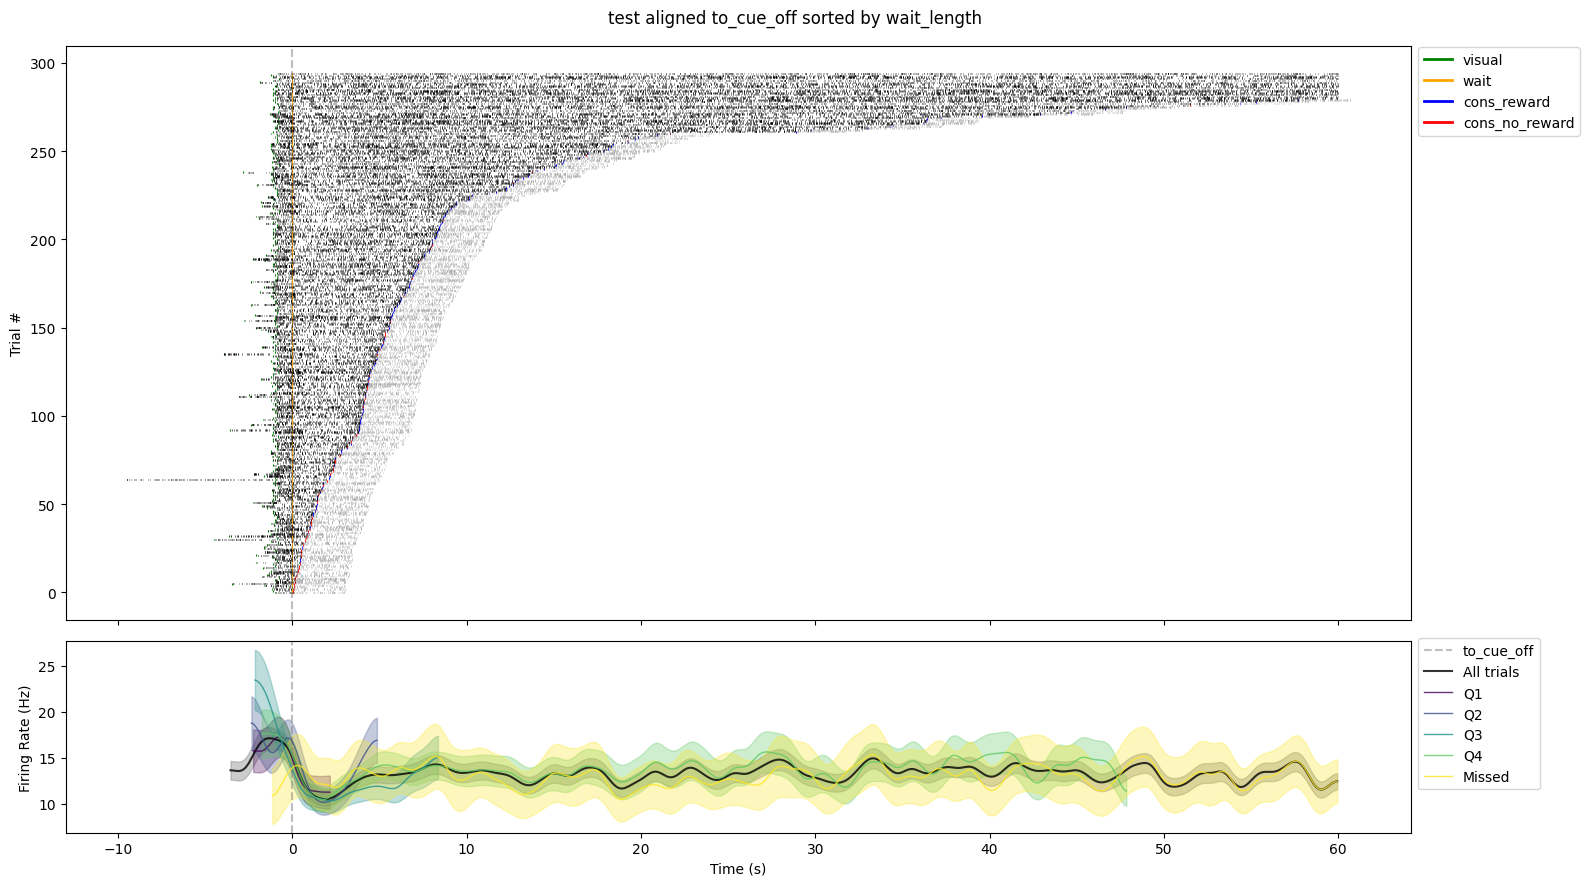

In [15]:
anchor = k.TO_CUE_OFF
sorter = k.WAIT_LENGTH
plot_raster_histo("test", events, trials, spikes,
                      anchor, k.anchored_periods, sorter,
                      time_step, sigma, trial_count_mask, 
                      save_fig=False, figure_folder=figure_dir, regenerate=False)

# Looping

loop through each anchor and sorter combo

In [16]:
time_step = 0.1
sigma = 2
trial_count_mask = 5
save_fig = True
regenerate = True

In [17]:
anchor_sorter_pairs = [
    (k.TO_CUE_ON, k.BACKGROUND_LENGTH),
    (k.TO_CUE_OFF, k.WAIT_LENGTH),
    (k.TO_DECISION, k.WAIT_LENGTH)
]

In [ ]:
# units_short= units_vetted.head(2)

: 

In [ ]:
failed_units = []
plotted = 0
total_plots = len(anchor_sorter_pairs) * len(units_vetted)
units_grouped = units_vetted.groupby("session_id")

for anchor, sorter in anchor_sorter_pairs:
    print(f"plotting anchor {anchor} sorted by {sorter}")
    
    for session_id, session_units in units_grouped:
        print(f"plotting {session_id}")
        print(f"{round((plotted/total_plots*100), 1)} % done")
        
        events, trials, units = utils.get_session_data(session_id, pickle_dir)
        
        region = session_units['region'].iloc[0]
        figure_folder = os.path.join(figure_dir, f"raster_histo_{anchor}_by_{sorter}", region)
        os.makedirs(figure_folder, exist_ok=True)
        
        for _, unit_info in session_units.iterrows():
            unit_id = unit_info['unit_id']
            spikes = units[unit_info['id']]
            figure_path = os.path.join(figure_folder, f"{unit_id}.png")
            
            if os.path.exists(figure_path) and not regenerate:
                continue
                
            try:
                plot_raster_histo(
                    unit_id, events, trials, spikes,
                    anchor, k.anchored_periods, sorter,
                    time_step, sigma, trial_count_mask,
                    save_fig, regenerate, figure_folder=figure_folder
                )
            except Exception as e:
                failed_units.append({
                    'unit_id': unit_id,
                    'error': str(e)
                })
            
            plotted += 1

# Print summary
if failed_units:
    print("\nFailed units:")
    for unit in failed_units:
        print(f"Session {unit['session_id']}, Unit {unit['unit_id']}: {unit['error']}")
    print(f"\nTotal failed: {len(failed_units)}/{len(units_vetted)}")
else:
    print("All units processed successfully!")

plotting anchor to_cue_on sorted by background_length
plotting RZ034_2024-07-13_str
0.0 % done
plotting RZ034_2024-07-13_v1
1.3 % done
plotting RZ034_2024-07-14_str
1.3 % done
plotting RZ036_2024-07-12_str
2.1 % done
plotting RZ036_2024-07-12_v1
3.4 % done
plotting RZ036_2024-07-13_str
3.9 % done
plotting RZ036_2024-07-13_v1
4.7 % done
plotting RZ036_2024-07-14_str
4.8 % done
plotting RZ037_2024-07-16_str
5.7 % done
plotting RZ037_2024-07-16_v1
7.3 % done
plotting RZ037_2024-07-17_str
7.4 % done
plotting RZ037_2024-07-18_str
9.2 % done
plotting RZ037_2024-07-18_v1
9.6 % done
plotting RZ038_2024-07-16_str
10.0 % done
plotting RZ038_2024-07-17_str
12.9 % done
plotting RZ038_2024-07-17_v1
12.9 % done
plotting RZ038_2024-07-18_str
12.9 % done
plotting RZ038_2024-07-19_str
13.9 % done
plotting RZ039_2024-07-17_str
14.4 % done
plotting RZ047_2024-11-19_str
15.0 % done
plotting RZ047_2024-11-20_str
15.9 % done
plotting RZ047_2024-11-20_v1
18.0 % done
plotting RZ047_2024-11-21_str
19.3 % done
